# Code for Figs. SM8-9

In [47]:
%load_ext autoreload
%autoreload 1
%aimport general_functions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

from general_functions import (compute_energies, complete_dynamics, g0_fun,
                               check_convergence, generate_hexagon, dos_general,
                               plot_band_structure, lattice_sites)

A triangular lattice is also study

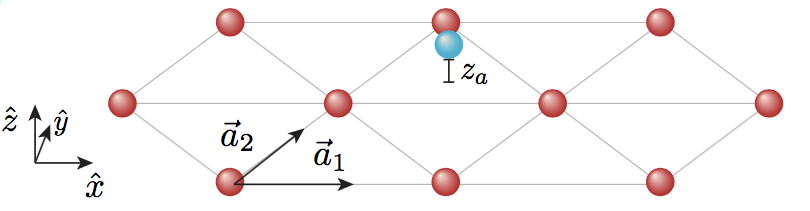

## Out-of plane polarization

### Band structure

In [49]:
polarizations = [np.array([[0, 0, 1]]).T]  # Polarization of lattice

d = 1  # Lattice constant
lambda0 = d / 0.1  # Wave-lenght of transition
k0 = 2 * np.pi / lambda0

aho = 0.1 * d  # Renormalization parameter

nmax = 9  # Number of reciprocal lattice in the summatory

# Reciprocal lattice vectors
b1 = 2 * np.pi / (np.sqrt(3) * d) * np.array([np.sqrt(3), -1])
b2 = 4 * np.pi / (np.sqrt(3) * d) * np.array([0, 1])

A = d ** 2 * np.sqrt(3) / 2  # Area of unit cell in real space

# Symmatric points
Gamma = [0, 0]  # 0
M = [np.pi / d, np.pi / (d * np.sqrt(3))]  # 1
K = [np.pi / d * (4 / 3), 0]  # 2

order = [1, 0, 2, 1]
points = [Gamma, M, K]
names = [r'$\Gamma$', r'$M$', r'$K$']

points_label = []
points_site = []

# Sort the symmetric points in the desired order
for i in order:
    points_label.append(names[i])
    points_site.append(points[i])
    
G0 = g0_fun(k0, aho)  # Renormalizated Green function in k = 0

In [50]:
# Check that the summatory in the reciprocal lattice has converged, is not, automatically increase the number of vectors
nmax, J_band, Gamma_band = check_convergence(points_site, b1, b2, A, nmax, k0, aho, G0=G0, n=100, limit_error=1e-5,
                                             print_progress=True, polarizations=polarizations, bands=None, step=2)

Step: 1, Avg error: 2.0125138693353566e-07


In [51]:
n = 401  # Number of momentum to evaluate in each direction (total sites is N = n²)

factor = np.pi / d * 4 / 3 / ((n - 1) / 2)
k_x, k_y = generate_hexagon(n, a=d)

k = np.vstack((k_x, k_y)).transpose()  # Momentum at which compute the bands
J, Gamma = compute_energies(b1, b2, A, nmax, k0, aho, k, G0=G0, polarizations=polarizations)  # Compute the energy in the given momentums

n_bands = np.shape(J)[1]  # Number of bands

In [52]:
# Limits for the energy
limit_sup = 40
limit_inf = -5

DoS = []
for i in range(n_bands):
    # Compute the DoS for each band
    energy, DoS_temp = dos_general(J[:, i], min_E=limit_inf, max_E=limit_sup, args=[0.01])
    DoS.append(DoS_temp)
    
DoS_total = sum(DoS)  # Total DoS, taking into account all the bands

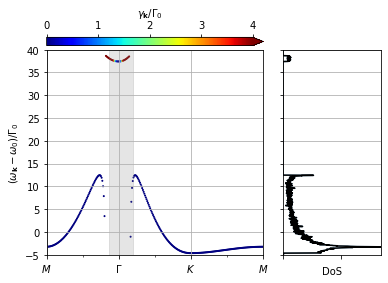

In [53]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 3), (0, 2))

light = [-k0 / np.sqrt(2) / np.pi, k0 / np.pi]

plot_band_structure(fig, ax1, J_band, Gamma_band, points_label, limit_inf=limit_inf, limit_sup=limit_sup,
                    label_cbar=r'$\gamma_\mathbf{k}/\Gamma_0$',
                    cbar_norm=4, limit_light=light, dos=DoS, energy_dos=energy, ax_dos=ax2)

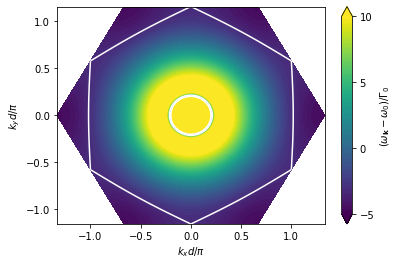

In [54]:
fig, ax = plt.subplots()

vmin = -5
vmax = 10

J_plot = J[:, 0]
J_plot[np.where(J_plot > vmax)] = vmax
J_plot[np.where(J_plot < vmin)] = vmin

triangles = tri.Triangulation(k[:, 0] / np.pi, k[:, 1] / np.pi)

for _ in range(3):
    tcf = ax.tricontourf(triangles, J_plot, vmin=vmin, vmax=vmax,
                         levels=np.linspace(vmin, vmax + 1e-10, int(np.ceil((vmax - vmin))) * 5), extend='both')
    
cbar = fig.colorbar(tcf, ticks=np.linspace(vmin, vmax, 4))
cbar.ax.set_ylabel(r'$(\omega_\mathbf{k} - \omega_0) / \Gamma_0$')

temp = np.abs(k[:, 1] - np.pi / (d * np.sqrt(3)))
index_temp = np.where(temp == np.min(temp))[0]
index_temp_2 = np.argmax(k[index_temp, 0])
index_m = index_temp[index_temp_2]
E_m = J_plot[index_m]
    
ax.tricontour(triangles, J_plot, colors='w', levels=[E_m], linestyles='-')
    
ax.set_xlabel(r'$k_x d/ \pi$')
ax.set_ylabel(r'$k_y d/ \pi$');

### Dynamics

In [69]:
pol_lat = np.array([[0, 0, 1]]).T # Polarization of the lattice
pol_emi = [np.array([[1, 1j, 0]]).T]  # Polarization of the emitter

border = 10 # Border of adiabatic lossees
max_gamma = 20  # Maximum individual free space decay rate in the border

n = 30
a1 = [d, 0]
a2 = [d / 2, d * np.sqrt(3) / 2]
x_pos, y_pos = [i.flatten() for i in lattice_sites(a1, a2, n, n)]

r = lambda x, sign: -np.sqrt(3) * x + n * np.sqrt(3) * sign

mask_top = np.where(y_pos < r(x_pos, 1))
x_pos = x_pos[mask_top]
y_pos = y_pos[mask_top]

mask_bottom = np.where(y_pos > r(x_pos, -1))
x_pos = x_pos[mask_bottom]
y_pos = y_pos[mask_bottom]

z_pos = np.zeros(len(x_pos))
r_pos = [x_pos, y_pos, z_pos]
n_array = len(z_pos)

gamma_emi = 0.002
omega_emi = -4.8077

n_e = len(pol_emi)

emitter = [[d / 2, d * np.sin(30 * np.pi / 180) / 2, 0.4]]

psi0 = np.zeros((n_array + n_e), dtype=complex)
psi0[-1] = 1

dt = 2e-5 / gamma_emi  # Time step
tf = dt * 2 ** 12  # Final time

In [56]:
results = complete_dynamics(r_pos, k0, pol_lat, dt, tf, psi0, emitter=emitter,
                            pol_emi=pol_emi, gamma_emi=gamma_emi,
                            omega_emi=omega_emi, border=border, max_gamma=max_gamma,
                            progress_bar=True)

psi = results['psi']
time = results['time']

In [57]:
p_e = np.abs(psi[:, -n_e:]) ** 2

p_r = np.abs(psi[:, :-n_e]) ** 2
p_r_total = np.sum(p_r, axis=-1)

k_x, k_y = generate_hexagon(1.5 * (n - 2), a=d)

# Non-uniform Fourier transform
temp = np.tensordot(k_x, x_pos, axes=0) + np.tensordot(k_y, y_pos, axes=0)
temp = np.exp(1j * temp)

p_k = np.zeros((len(time), len(k_x)))

for  i in range(len(time)):
    p_k[i] = np.abs(temp @ psi[i, :-n_e]) ** 2
    
index_max = np.argmax(np.sum(p_r, -1))

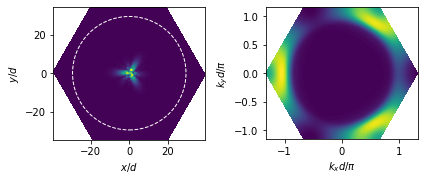

In [58]:
triangles_r = tri.Triangulation(r_pos[0], r_pos[1])
triangles_k = tri.Triangulation(k_x / np.pi, k_y / np.pi)
r = np.sqrt(r_pos[0] ** 2 + r_pos[1] ** 2)

fig, [ax1, ax2] = plt.subplots(1, 2)

vmax = np.max(p_r[index_max])
cnt = ax1.tricontourf(triangles_r, p_r[index_max], vmin=0, vmax=vmax,
                      levels=np.linspace(0, vmax, 100))

ax1.set_aspect('equal')
ax1.set_xlabel(r'$x/d$')
ax1.set_ylabel(r'$y/d$')

circle = plt.Circle((0, 0), min(r[results['indices_border']]) , color='w', fill=False, ls='--', alpha=1)
ax1.add_artist(circle)

vmax = np.max(p_k[index_max])
cnt = ax2.tricontourf(triangles_k, p_k[index_max], vmin=0, vmax=vmax,
                      levels=np.linspace(0, vmax, 100))

ax2.set_aspect('equal')
ax2.set_xlabel(r'$k_x d/\pi$')
ax2.set_ylabel(r'$k_y d/\pi$')

fig.tight_layout()

## In-plane polarization

### Band structure

In [59]:
polarizations = [np.array([[1, 0, 0]]).T]  # Polarization of lattice

d = 1  # Lattice constant
lambda0 = d / 0.278  # Wave-lenght of transition
k0 = 2 * np.pi / lambda0

aho = 0.1 * d  # Renormalization parameter

nmax = 9  # Number of reciprocal lattice in the summatory
   
G0 = g0_fun(k0, aho)  # Renormalizated Green function in k = 0

In [60]:
# Check that the summatory in the reciprocal lattice has converged, is not, automatically increase the number of vectors
nmax, J_band, Gamma_band = check_convergence(points_site, b1, b2, A, nmax, k0, aho, G0=G0, n=100, limit_error=1e-5,
                                             print_progress=True, polarizations=polarizations, bands=None, step=2)

Step: 1, Avg error: 2.614973028291362e-07


In [61]:
n = 401  # Number of momentum to evalueate in each direction (total sites is N = n²)

factor = np.pi / d * 4 / 3 / ((n - 1) / 2)
k_x, k_y = generate_hexagon(n, a=d)

k = np.vstack((k_x, k_y)).transpose()  # Momentum at which compute the bands
J, Gamma = compute_energies(b1, b2, A, nmax, k0, aho, k, G0=G0, polarizations=polarizations)  # Compute the energy in the given momentums

n_bands = np.shape(J)[1]  # Number of bands

In [62]:
# Limits for the energy
limit_sup = 1.6
limit_inf = 0.4

DoS = []
for i in range(n_bands):
    # Compute the DoS for each band
    energy, DoS_temp = dos_general(J[:, i], min_E=limit_inf, max_E=limit_sup, args=[0.01])
    DoS.append(DoS_temp)
    
DoS_total = sum(DoS)  # Total DoS, taking into account all the bands

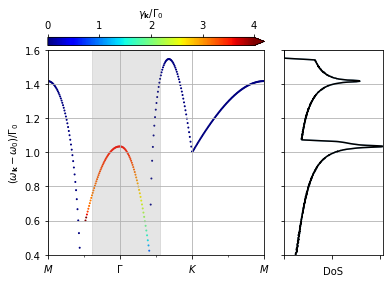

In [63]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 3), (0, 2))

light = [-k0 / np.sqrt(2) / np.pi, k0 / np.pi]

plot_band_structure(fig, ax1, J_band, Gamma_band, points_label, limit_inf=limit_inf, limit_sup=limit_sup,
                    label_cbar=r'$\gamma_\mathbf{k}/\Gamma_0$',
                    cbar_norm=4, limit_light=light, dos=DoS, energy_dos=energy, ax_dos=ax2)

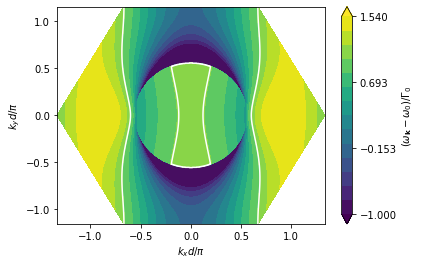

In [64]:
fig, ax = plt.subplots()

vmin = -1
vmax = 1.54

J_plot = J[:, 0]
J_plot[np.where(J_plot > vmax)] = vmax
J_plot[np.where(J_plot < vmin)] = vmin

triangles = tri.Triangulation(k[:, 0] / np.pi, k[:, 1] / np.pi)

for _ in range(3):
    tcf = ax.tricontourf(triangles, J_plot, vmin=vmin, vmax=vmax,
                         levels=np.linspace(vmin, vmax + 1e-10, int(np.ceil((vmax - vmin))) * 5), extend='both')
    
cbar = fig.colorbar(tcf, ticks=np.linspace(vmin, vmax, 4))
cbar.ax.set_ylabel(r'$(\omega_\mathbf{k} - \omega_0) / \Gamma_0$')

index_k = np.where(k[:, 1] == np.max(k[:, 1]))[0][-1]
E_k = J_plot[index_k]
    
ax.tricontour(triangles, J_plot, colors='w', levels=[E_k], linestyles='-')
    
ax.set_xlabel(r'$k_x d/ \pi$')
ax.set_ylabel(r'$k_y d/ \pi$');

### Dynamics

In [70]:
pol_lat = np.array([[1, 0, 0]]).T # Polarization of the lattice
pol_emi = [np.array([[1, 1j, 0]]).T]  # Polarization of the emitter

n = 30
omega_emi = 0.5

In [71]:
results = complete_dynamics(r_pos, k0, pol_lat, dt, tf, psi0, emitter=emitter,
                            pol_emi=pol_emi, gamma_emi=gamma_emi,
                            omega_emi=omega_emi, border=border, max_gamma=max_gamma,
                            progress_bar=True)

psi = results['psi']
time = results['time']

   Time evolution:   0%|          | 0/4096 [00:00<?, ?it/s]

In [72]:
p_e = np.abs(psi[:, -n_e:]) ** 2

p_r = np.abs(psi[:, :-n_e]) ** 2
p_r_total = np.sum(p_r, axis=-1)

k_x, k_y = generate_hexagon(1.5 * (n - 2), a=d)

temp = np.tensordot(k_x, x_pos, axes=0) + np.tensordot(k_y, y_pos, axes=0)
temp = np.exp(1j * temp)

p_k = np.zeros((len(time), len(k_x)))

for  i in range(len(time)):
    p_k[i] = np.abs(temp @ psi[i, :-n_e]) ** 2
    
index_max = np.argmax(np.sum(p_r, -1))

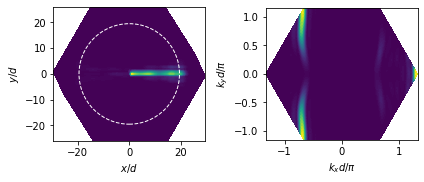

In [74]:
triangles_r = tri.Triangulation(r_pos[0], r_pos[1])
triangles_k = tri.Triangulation(k_x / np.pi, k_y / np.pi)
r = np.sqrt(r_pos[0] ** 2 + r_pos[1] ** 2)

fig, [ax1, ax2] = plt.subplots(1, 2)

vmax = np.max(p_r[index_max])
cnt = ax1.tricontourf(triangles_r, p_r[index_max], vmin=0, vmax=vmax,
                      levels=np.linspace(0, vmax, 100))

ax1.set_aspect('equal')
ax1.set_xlabel(r'$x/d$')
ax1.set_ylabel(r'$y/d$')

circle = plt.Circle((0, 0), min(r[results['indices_border']]) , color='w', fill=False, ls='--', alpha=1)
ax1.add_artist(circle)

vmax = np.max(p_k[index_max])
cnt = ax2.tricontourf(triangles_k, p_k[index_max], vmin=0, vmax=vmax,
                      levels=np.linspace(0, vmax, 100))

ax2.set_aspect('equal')
ax2.set_xlabel(r'$k_x d/\pi$')
ax2.set_ylabel(r'$k_y d/\pi$')

fig.tight_layout()